In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
import tensorflow_datasets as tfds
import os
import PIL
import PIL.Image
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense

In [10]:
batch_size = 10
# original batch 32
img_height = 224
img_width = 224

In [11]:
dataset = "images"


#### To gray

In [12]:
# %pip install opencv-python

In [13]:
import cv2
import glob 
%matplotlib inline

In [14]:
count = 1

gray_dataset = dataset

for path in gray_dataset:
    
    filenames = glob.glob(path)

    for filename in filenames:
        
        image = cv2.imread(filename)
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        image = cv2.resize(image, (128, 128))
        gray_img = cv2.resize(gray_img, (128, 128))
    
        cv2.imwrite("gray_images/gray_" +str(count) +".jpg", gray_img)
        cv2.imwrite("color_images/color_" +str(count) +".jpg", image)
    
        count += 1
plt.show('images\workers\worker2.jpg')

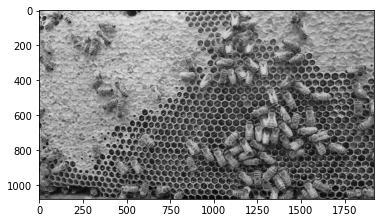

In [15]:
image = cv2.imread('images\workers\worker2.jpg')
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
# plt.show()

#### Split

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=dataset,
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  crop_to_aspect_ratio=True)


Found 1604 files belonging to 2 classes.
Using 1284 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1604 files belonging to 2 classes.
Using 320 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['queens', 'workers']


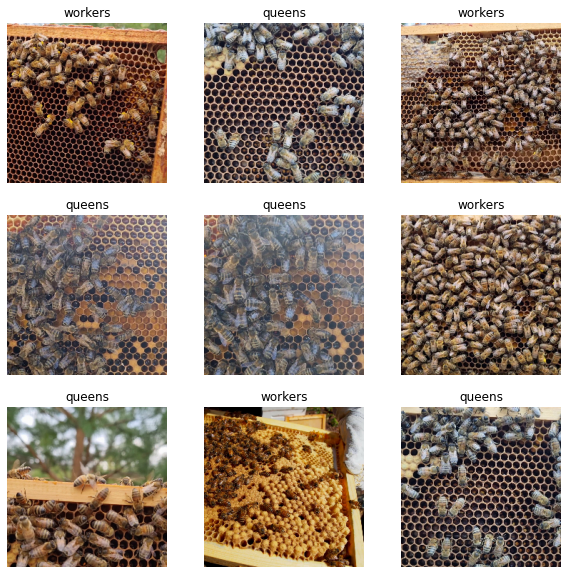

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 224, 224, 3)
(10,)


#### Preparation

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(47).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# original shuffle 1000

In [22]:
normalization_layer = layers.Rescaling(1./255)

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


#### Augmentation

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

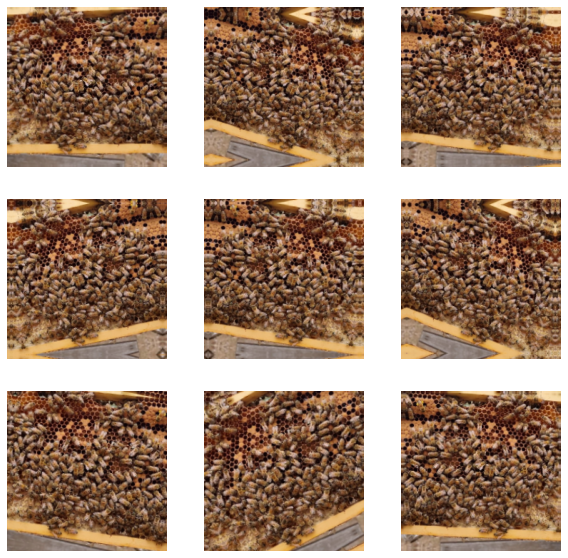

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Model - Sequential

In [26]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)       

In [29]:
epochs=16
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/16
129/129 [==============================] - 39s 281ms/step - loss: 0.5106 - accuracy: 0.7749 - val_loss: 0.2813 - val_accuracy: 0.8813
Epoch 2/16
129/129 [==============================] - 31s 242ms/step - loss: 0.1955 - accuracy: 0.9276 - val_loss: 0.2273 - val_accuracy: 0.9000
Epoch 3/16
129/129 [==============================] - 32s 246ms/step - loss: 0.1210 - accuracy: 0.9626 - val_loss: 0.2381 - val_accuracy: 0.9062
Epoch 4/16
129/129 [==============================] - 33s 252ms/step - loss: 0.0552 - accuracy: 0.9774 - val_loss: 0.3654 - val_accuracy: 0.9094
Epoch 5/16
129/129 [==============================] - 33s 256ms/step - loss: 0.0607 - accuracy: 0.9821 - val_loss: 0.3342 - val_accuracy: 0.8750
Epoch 6/16
129/129 [==============================] - 32s 246ms/step - loss: 0.0625 - accuracy: 0.9766 - val_loss: 0.4157 - val_accuracy: 0.8719
Epoch 7/16
129/129 [==============================] - 34s 262ms/step - loss: 0.0247 - accuracy: 0.9922 - val_loss: 0.3910 - val_ac

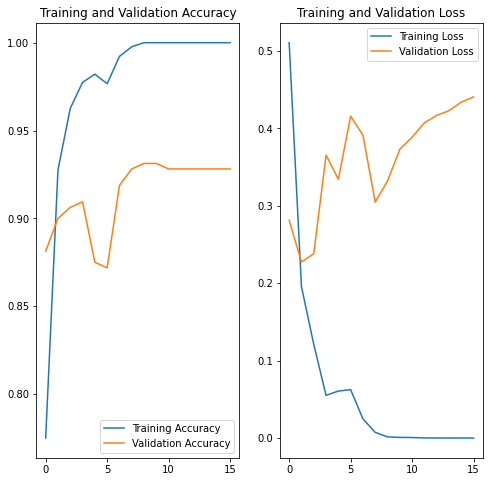

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()